# Plotting Custom Metric Results


In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

from sae_bench_utils.graphing_utils import (
    plot_2var_graph,
    plot_3var_graph,
    plot_2var_graph_dict_size,
    plot_interactive_3var_graph,
    plot_training_steps,
    plot_correlation_heatmap,
    plot_correlation_scatter,
)

from sae_bench_utils.formatting_utils import (
    get_sparsity_penalty,
    extract_saes_unique_info,
    ae_config_results,
    add_custom_metric_results,
    filter_by_l0_threshold,
    make_available_sae_df,
)

from sae_bench_utils.sae_selection_utils import (select_saes_multiple_patterns)

## Load data


In [30]:
eval_path = "./evals/mdl"
image_path = os.path.join(eval_path, "images")
results_path = os.path.join(eval_path, "results")

if not os.path.exists(image_path):
    os.makedirs(image_path)

In [31]:
sae_regex_patterns = [
    r"(sae_bench_pythia70m_sweep_topk_ctx128_0730).*",
    r"(sae_bench_pythia70m_sweep_standard_ctx128_0712).*",
]
sae_block_pattern = [
    r".*blocks\.([4])\.hook_resid_post__trainer_(1|2|5|6|9|10|17|18)$",
    r".*blocks\.([4])\.hook_resid_post__trainer_(1|2|5|6|9|10|17|18)$",
]

selected_saes_dict = select_saes_multiple_patterns(
    sae_regex_patterns, sae_block_pattern
)

eval_results = {}
for sae_release in selected_saes_dict:
    for sae_id in selected_saes_dict[sae_release]:
        filename = f"{sae_release}_{sae_id}_eval_results.json".replace("/", "_")
        filepath = os.path.join(results_path, filename)

        if not os.path.exists(filepath):
            print(f"File {filepath} does not exist")
            continue

        with open(filepath, "r") as f:
            single_sae_results = json.load(f)

        eval_results[f"{sae_release}_{sae_id}"] = single_sae_results['eval_results'][-1]
        num_bins = eval_results[f"{sae_release}_{sae_id}"]["num_bins"]
        print(num_bins)

        print(single_sae_results['eval_results'][-1])

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:00<00:00, 80596.43it/s]

SAE release: sae_bench_pythia70m_sweep_topk_ctx128_0730, Number of SAEs: 8
Sample SAEs: ['blocks.4.hook_resid_post__trainer_1', 'blocks.4.hook_resid_post__trainer_10', 'blocks.4.hook_resid_post__trainer_17', 'blocks.4.hook_resid_post__trainer_18', 'blocks.4.hook_resid_post__trainer_2']...
SAE release: sae_bench_pythia70m_sweep_standard_ctx128_0712, Number of SAEs: 8
Sample SAEs: ['blocks.4.hook_resid_post__trainer_1', 'blocks.4.hook_resid_post__trainer_10', 'blocks.4.hook_resid_post__trainer_17', 'blocks.4.hook_resid_post__trainer_18', 'blocks.4.hook_resid_post__trainer_2']...
64
{'num_bins': 64, 'bins': [], 'k': None, 'description_length': 145.26412963867188, 'within_threshold': True, 'mse_loss': 0.02346399426460266}
64
{'num_bins': 64, 'bins': [], 'k': None, 'description_length': 532.358154296875, 'within_threshold': True, 'mse_loss': 0.05016442760825157}
64
{'num_bins': 64, 'bins': [], 'k': None, 'description_length': 952.2614135742188, 'within_threshold': True, 'mse_loss': 0.007830

100%|██████████| 49/49 [00:00<00:00, 74816.49it/s]

SAE release: sae_bench_pythia70m_sweep_topk_ctx128_0730, Number of SAEs: 8
Sample SAEs: ['blocks.4.hook_resid_post__trainer_1', 'blocks.4.hook_resid_post__trainer_10', 'blocks.4.hook_resid_post__trainer_17', 'blocks.4.hook_resid_post__trainer_18', 'blocks.4.hook_resid_post__trainer_2']...
SAE release: sae_bench_pythia70m_sweep_standard_ctx128_0712, Number of SAEs: 8
Sample SAEs: ['blocks.4.hook_resid_post__trainer_1', 'blocks.4.hook_resid_post__trainer_10', 'blocks.4.hook_resid_post__trainer_17', 'blocks.4.hook_resid_post__trainer_18', 'blocks.4.hook_resid_post__trainer_2']...


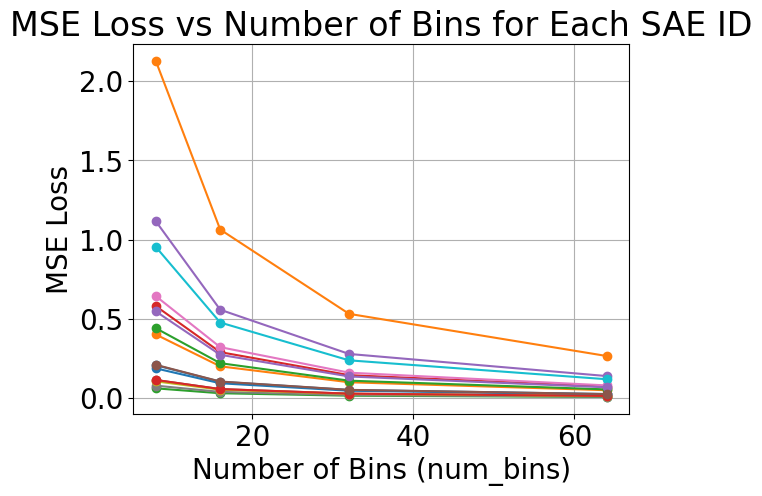

In [43]:
sae_regex_patterns = [
    r"(sae_bench_pythia70m_sweep_topk_ctx128_0730).*",
    r"(sae_bench_pythia70m_sweep_standard_ctx128_0712).*",
]
sae_block_pattern = [
    r".*blocks\.([4])\.hook_resid_post__trainer_(1|2|5|6|9|10|17|18)$",
    r".*blocks\.([4])\.hook_resid_post__trainer_(1|2|5|6|9|10|17|18)$",
]

selected_saes_dict = select_saes_multiple_patterns(
    sae_regex_patterns, sae_block_pattern
)

eval_results = {}
for sae_release in selected_saes_dict:
    for sae_id in selected_saes_dict[sae_release]:
        filename = f"{sae_release}_{sae_id}_eval_results.json".replace("/", "_")
        filepath = os.path.join(results_path, filename)

        if not os.path.exists(filepath):
            print(f"File {filepath} does not exist")
            continue

        with open(filepath, "r") as f:
            single_sae_results = json.load(f)

        eval_results[f"{sae_release}_{sae_id}"] = single_sae_results['eval_results'][-1]
        values = single_sae_results['eval_results']
        num_bins = [entry['num_bins'] for entry in values]
        mse_loss = [entry['mse_loss'] for entry in values]
    
        # Plotting the line for the current sae_id
        plt.plot(num_bins, mse_loss, marker='o', label=sae_id)

# Customizing plot
plt.xlabel("Number of Bins (num_bins)")
plt.ylabel("MSE Loss")
plt.title("MSE Loss vs Number of Bins for Each SAE ID")
# plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 49/49 [00:00<00:00, 68621.33it/s]

SAE release: sae_bench_pythia70m_sweep_topk_ctx128_0730, Number of SAEs: 8
Sample SAEs: ['blocks.4.hook_resid_post__trainer_1', 'blocks.4.hook_resid_post__trainer_10', 'blocks.4.hook_resid_post__trainer_17', 'blocks.4.hook_resid_post__trainer_18', 'blocks.4.hook_resid_post__trainer_2']...
SAE release: sae_bench_pythia70m_sweep_standard_ctx128_0712, Number of SAEs: 8
Sample SAEs: ['blocks.4.hook_resid_post__trainer_1', 'blocks.4.hook_resid_post__trainer_10', 'blocks.4.hook_resid_post__trainer_17', 'blocks.4.hook_resid_post__trainer_18', 'blocks.4.hook_resid_post__trainer_2']...


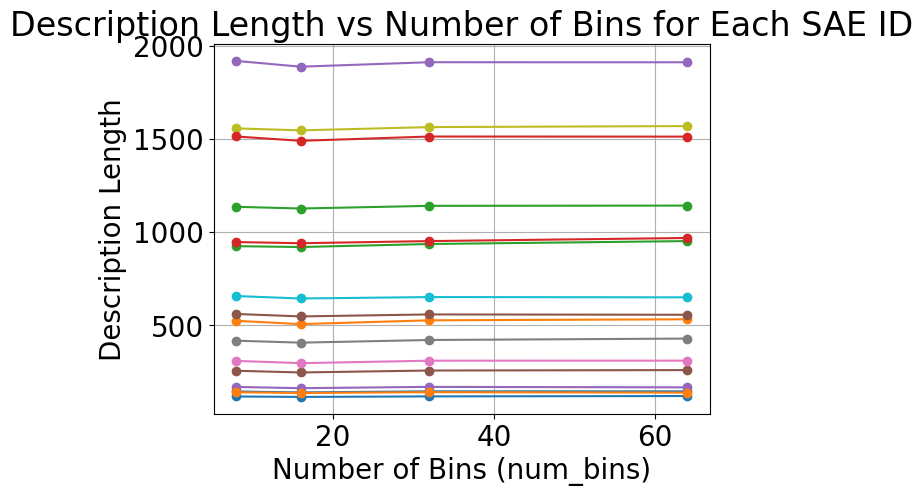

In [44]:
sae_regex_patterns = [
    r"(sae_bench_pythia70m_sweep_topk_ctx128_0730).*",
    r"(sae_bench_pythia70m_sweep_standard_ctx128_0712).*",
]
sae_block_pattern = [
    r".*blocks\.([4])\.hook_resid_post__trainer_(1|2|5|6|9|10|17|18)$",
    r".*blocks\.([4])\.hook_resid_post__trainer_(1|2|5|6|9|10|17|18)$",
]

selected_saes_dict = select_saes_multiple_patterns(
    sae_regex_patterns, sae_block_pattern
)

eval_results = {}
for sae_release in selected_saes_dict:
    for sae_id in selected_saes_dict[sae_release]:
        filename = f"{sae_release}_{sae_id}_eval_results.json".replace("/", "_")
        filepath = os.path.join(results_path, filename)

        if not os.path.exists(filepath):
            print(f"File {filepath} does not exist")
            continue

        with open(filepath, "r") as f:
            single_sae_results = json.load(f)

        eval_results[f"{sae_release}_{sae_id}"] = single_sae_results['eval_results'][-1]
        values = single_sae_results['eval_results']
        num_bins = [entry['num_bins'] for entry in values]
        mse_loss = [entry['description_length'] for entry in values]
    
        # Plotting the line for the current sae_id
        plt.plot(num_bins, mse_loss, marker='o', label=sae_id)

# Customizing plot
plt.xlabel("Number of Bins (num_bins)")
plt.ylabel("Description Length")
plt.title("Description Length vs Number of Bins for Each SAE ID")
# plt.legend()
plt.grid(True)
plt.show()

In [34]:
sae_names = list(eval_results.keys())

print(eval_results.keys())
print("\nAvailable SAEs:\n", eval_results.keys())
print(
    "\nAvailable custom metrics:\n", eval_results[sae_names[0]].keys()
)

dict_keys(['sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_1', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_10', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_17', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_18', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_2', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_5', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_6', 'sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_9', 'sae_bench_pythia70m_sweep_standard_ctx128_0712_blocks.4.hook_resid_post__trainer_1', 'sae_bench_pythia70m_sweep_standard_ctx128_0712_blocks.4.hook_resid_post__trainer_10', 'sae_bench_pythia70m_sweep_standard_ctx128_0712_blocks.4.hook_resid_post__trainer_17', 'sae_bench_pythia70m_sweep_standard_ctx128_0712_blocks.4.hook_resid_po

In this cell, we find all of the sae_releases for the data file, and aggregate
all of the data into `sae_data`. `sae_data` contains basic metrics like L0 and
Loss Recovered, in addition to trainer parameters like dict size, sparsity
penalty, SAE type, etc.


In [35]:


sae_data = {"basic_eval_results": {}, "sae_config_dictionary_learning": {}}

for release_name in selected_saes_dict.keys():
    sae_data_filename = f"sae_bench_data/{release_name}_data.json"

    with open(sae_data_filename, "r") as f:
        sae_release_data = json.load(f)

    sae_data["basic_eval_results"].update(sae_release_data["basic_eval_results"])
    sae_data["sae_config_dictionary_learning"].update(
        sae_release_data["sae_config_dictionary_learning"]
    )

In [36]:
print(sae_data.keys())
# print('\nAvailable SAEs:\n', sae_data["basic_eval_results"].keys())

first_sae_name = next(iter(sae_data["basic_eval_results"]))
print(first_sae_name)
print("\nAvailable basic metrics:\n", sae_data["basic_eval_results"][first_sae_name].keys())

dict_keys(['basic_eval_results', 'sae_config_dictionary_learning'])
pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_18

Available basic metrics:
 dict_keys(['l2_loss', 'l1_loss', 'l0', 'frac_variance_explained', 'cossim', 'l2_ratio', 'relative_reconstruction_bias', 'loss_original', 'loss_reconstructed', 'loss_zero', 'frac_recovered', 'frac_alive', 'hyperparameters'])


In [37]:
# Gather all values in one dict for plotting
plotting_results = eval_results

sae_df = make_available_sae_df(for_printing=False)

for sae_name in eval_results:

    # sae_bench data is currently stored using the sae_name, not sae_id, as the key. So we need to do this hacky conversion
    if "sae_bench" in sae_name:
        sae_release = sae_name.split("_blocks")[0]
        sae_id = "blocks" + sae_name.split("_blocks")[1]

        sae_id_to_name_map = sae_df.saes_map[sae_release]
        sae_data_name = sae_id_to_name_map[sae_id]

    plotting_results[sae_name]["l0"] = sae_data["basic_eval_results"][sae_data_name]["l0"]
    plotting_results[sae_name]["sparsity_penalty"] = get_sparsity_penalty(
        sae_data["sae_config_dictionary_learning"][sae_data_name]
    )
    plotting_results[sae_name]["frac_recovered"] = sae_data["basic_eval_results"][sae_data_name][
        "frac_recovered"
    ]

    # Add all trainer info
    plotting_results[sae_name] = (
        plotting_results[sae_name]
        | sae_data["sae_config_dictionary_learning"][sae_data_name]["trainer"]
    )
    plotting_results[sae_name]["buffer"] = sae_data["sae_config_dictionary_learning"][
        sae_data_name
    ]["buffer"]

## Plot custom metric above unsupervised metrics


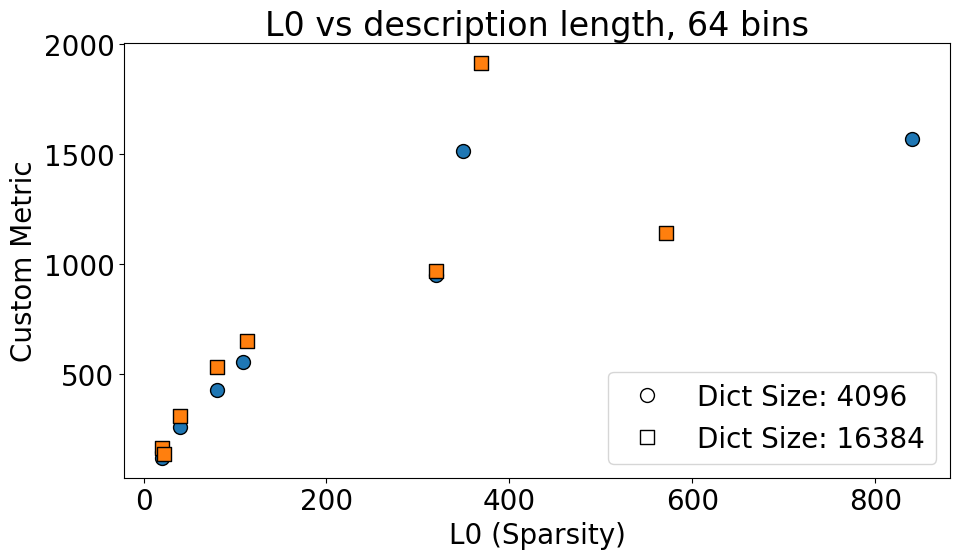

In [38]:
k = 1
custom_metric = f"sae_top_{k}_test_accuracy"
custom_metric = "description_length"
# custom_metric = "mse_loss"
# custom_metric = "llm_top_1_test_accuracy"
custom_metric_name = f"description length, {num_bins} bins"
# custom_metric_name = f"k={k}-Sparse Probe Accuracy"
title_3var = f"L0 vs Loss Recovered vs {custom_metric_name}"
title_2var = f"L0 vs {custom_metric_name}"
image_base_name = os.path.join(image_path, custom_metric)

# plot_3var_graph(
#     plotting_results,
#     title_3var,
#     custom_metric,
#     colorbar_label="Custom Metric",
#     output_filename=f"{image_base_name}_3var.png",
# )
plot_2var_graph_dict_size(
    plotting_results,
    custom_metric,
    title=title_2var,
    output_filename=f"{image_base_name}_2var.png",
)
# plot_interactive_3var_graph(plotting_results, custom_metric)

# At this point, if there's any additional .json files located alongside the ae.pt and eval_results.json
# You can easily adapt them to be included in the plotting_results dictionary by using something similar to add_ae_config_results()

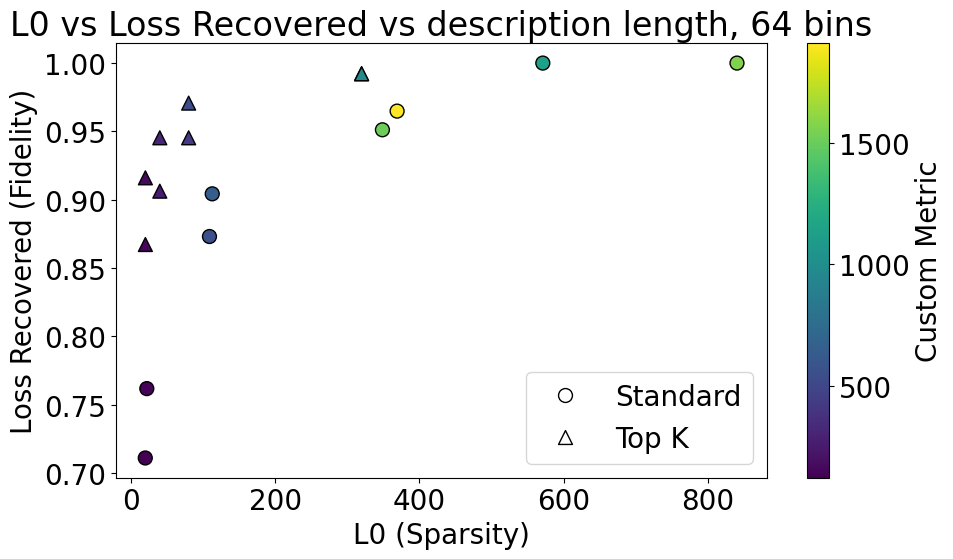

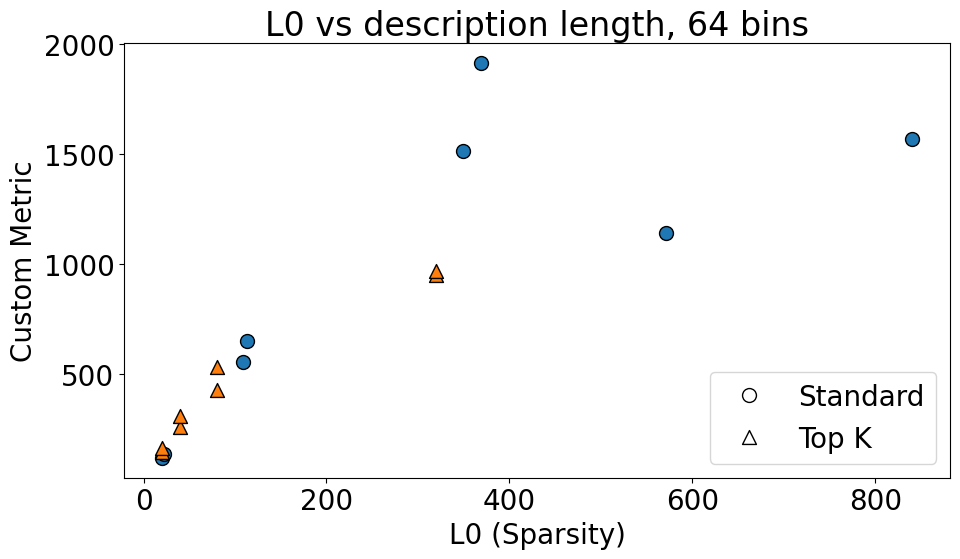

In [42]:
k = 1
custom_metric = f"sae_top_{k}_test_accuracy"
custom_metric = "description_length"
# custom_metric = "mse_loss"
# custom_metric = "llm_top_1_test_accuracy"
custom_metric_name = f"description length, {num_bins} bins"
# custom_metric_name = f"k={k}-Sparse Probe Accuracy"
title_3var = f"L0 vs Loss Recovered vs {custom_metric_name}"
title_2var = f"L0 vs {custom_metric_name}"
image_base_name = os.path.join(image_path, custom_metric)

plot_3var_graph(
    plotting_results,
    title_3var,
    custom_metric,
    colorbar_label="Custom Metric",
    output_filename=f"{image_base_name}_3var.png",
)
plot_2var_graph(
    plotting_results,
    custom_metric,
    title=title_2var,
    output_filename=f"{image_base_name}_2var.png",
)
# plot_interactive_3var_graph(plotting_results, custom_metric)

# At this point, if there's any additional .json files located alongside the ae.pt and eval_results.json
# You can easily adapt them to be included in the plotting_results dictionary by using something similar to add_ae_config_results()

### ...with interactive hovering


In [ ]:
plot_interactive_3var_graph(
    plotting_results,
    custom_metric,
    title=title_3var,
    output_filename=f"{image_base_name}_3var_interactive.html",
)

## Plot metric over training checkpoints


Note: We have SAE checkpoints at initialization (step 0), which does not fit on
a log scale (log(0) = -inf). We visualize this with a cut in the graph.

In [ ]:
plot_training_steps(
    plotting_results,
    custom_metric,
    title=f"Steps vs {custom_metric_name} Gemma Layer {layer}",
    output_filename=f"{image_base_name}_steps_vs_diff.png",
)

This cell combines all of the above steps into a single function so we can plot results from multiple runs.

In [ ]:
def plot_results(results_path: str, filename: str, custom_metric: str, custom_metric_name: str, layer: int):

    filepath = os.path.join(results_path, filename)

    with open(filepath, "r") as f:
        eval_results = json.load(f)

    sae_releases = eval_results["custom_eval_config"]["sae_releases"]

    sae_data = {"basic_eval_results": {}, "sae_config_dictionary_learning": {}}

    for release_name in sae_releases:
        sae_data_filename = f"sae_bench_data/{release_name}_data.json"

        with open(sae_data_filename, "r") as f:
            sae_release_data = json.load(f)

        sae_data["basic_eval_results"].update(sae_release_data["basic_eval_results"])
        sae_data["sae_config_dictionary_learning"].update(
            sae_release_data["sae_config_dictionary_learning"]
        )

    # Gather all values in one dict for plotting
    plotting_results = eval_results

    for sae_name in eval_results:
        plotting_results[sae_name]["l0"] = sae_data["basic_eval_results"][sae_name]["l0"]
        plotting_results[sae_name]["sparsity_penalty"] = get_sparsity_penalty(
            sae_data["sae_config_dictionary_learning"][sae_name]
        )
        plotting_results[sae_name]["frac_recovered"] = sae_data["basic_eval_results"][sae_name][
            "frac_recovered"
        ]

        # Add all trainer info
        plotting_results[sae_name] = (
            plotting_results[sae_name]
            | sae_data["sae_config_dictionary_learning"][sae_name]["trainer"]
        )
        plotting_results[sae_name]["buffer"] = sae_data["sae_config_dictionary_learning"][
            sae_name
        ]["buffer"]

    title_3var = f"L0 vs Loss Recovered vs {custom_metric_name}"
    title_2var = f"L0 vs {custom_metric_name}, Layer {layer}, Gemma-2-2B"
    image_base_name = os.path.join(image_path, custom_metric)

    # plot_3var_graph(
    #     plotting_results,
    #     title_3var,
    #     custom_metric,
    #     colorbar_label="Custom Metric",
    #     output_filename=f"{image_base_name}_3var.png",
    # )
    plot_2var_graph(
        plotting_results,
        custom_metric,
        title=title_2var,
        output_filename=f"{image_base_name}_2var.png",
        y_label=custom_metric_name,
    )

    if "checkpoints" in filename:
        plot_training_steps(
            plotting_results,
            custom_metric,
            y_label=custom_metric_name,
            title=f"Steps vs {custom_metric_name}",
            output_filename=f"{image_base_name}_steps_vs_diff.png",
        )

eval_path = "./evals/sparse_probing"
eval_path = "./evals/shift_and_tpp"
image_path = os.path.join(eval_path, "images")
results_path = os.path.join(eval_path, "results")

if not os.path.exists(image_path):
    os.makedirs(image_path)


k = 10

if "sparse_probing" in eval_path:
    custom_metric = f"sae_top_{k}_test_accuracy"
    custom_metric_name = f"k={k}-Sparse Probe Accuracy"
elif "shift_and_tpp" in eval_path:
    custom_metric = f"scr_metric_threshold_{k}"
    custom_metric_name = f"SCR {k} latents"
else:
    raise ValueError("Unknown eval path")


for layer in [3, 11, 19]:
    filename = f"gemma-2-2b_layer_{layer}_eval_results.json"

    if "shift_and_tpp" in eval_path:
        filename = f"gemma-2-2b_scr_layer_{layer}_eval_results.json"

    # filename = f"gemma-2-2b_layer_{i}_with_checkpoints_eval_results.json"

    plot_results(results_path, filename, custom_metric, custom_metric_name, layer)

## Plot metric correlations


In [ ]:
# k=100
# custom_metric = f'sae_top_{k}_test_accuracy'

metric_keys = [
    "l0",
    "frac_recovered",
    custom_metric,
]

plot_correlation_heatmap(plotting_results, metric_names=metric_keys, ae_names=None)

In [ ]:
# Simple example usage:
# plot_metric_scatter(plotting_results, metric_x="l0", metric_y="frac_recovered", title="L0 vs Fraction Recovered")

threshold_x = 50
threshold_y = 100

metric_x = f"sae_top_{threshold_x}_test_accuracy"
metric_y = f"sae_top_{threshold_y}_test_accuracy"

title = f""
x_label = "k=1 Sparse Probe Accuracy"
y_label = "k=100 Sparse Probe Accuracy"
output_filename = os.path.join(
    image_path,
    f"sparse_probing_result_correlation_for_thresholds_{threshold_y}_{threshold_y}.png",
)

plot_correlation_scatter(
    plotting_results,
    metric_x=metric_x,
    metric_y=metric_y,
    title=title,
    x_label=x_label,
    y_label=y_label,
    output_filename=output_filename,
)